In [28]:
#Import libraries
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import galsim
import time
from galsim.gsparams import GSParams
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import shape_measurement as sm

In [29]:
#gsparams=galsim.GSParams()
gsparams = galsim.GSParams(kvalue_accuracy=1.e-8,maximum_fft_size=2048*8,maxk_threshold=1.e-6)
#gsparams = galsim.GSParams(maximum_fft_size=2048*8)

In [30]:
def makeGaussian(im, flux=1., gsparams=None):
    im_mom = galsim.hsm.FindAdaptiveMom(im,strict=False)
    if im_mom.moments_status != 0:
        #print im_mom.correction_status
        return False, False, False
    else:
        im_mom_sigma, im_mom_shear = im_mom.moments_sigma*im.scale, im_mom.observed_shape
        im_gaussian = galsim.Gaussian(sigma=im_mom_sigma, flux=flux, gsparams=gsparams)
        #im_gaussian = im_gaussian.shear(g1=im_mom_shear.g1,g2=im_mom_shear.g2)
        return im_gaussian, im_mom_sigma, im_mom_shear


In [31]:
pixel_scale = 0.1 #as/px
lamda = 550 #nm
diameter = 1.2 #m
airy = galsim.Airy(lam=lamda, diam=diameter, scale_unit=galsim.arcsec, obscuration=0.3, gsparams=gsparams)
pixel = galsim.Pixel(pixel_scale,gsparams=gsparams)
psf = galsim.Convolve(airy, pixel)

#image_psf = psf.drawImage(scale=pixel_scale/20.,method='no_pixel') #Fit a Gaussian
#psf_gaussian = makeGaussian(image_psf,gsparams=gsparams)[0]
psf_gaussian = psf #Now a misnomer, make it Airy

given_psf = psf_gaussian.drawImage(scale=pixel_scale/10.,method='no_pixel') #Draw oversampled psf image

#gauss_psfii = psf_gaussian
gauss_psfii = galsim.InterpolatedImage(given_psf, gsparams=gsparams)


(1098, 1098)


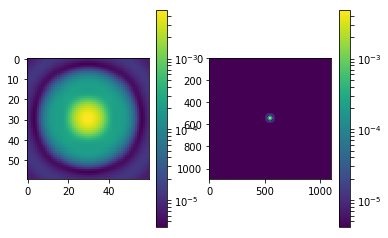

In [32]:
fig,ax=plt.subplots(1,2)
stamp=galsim.ImageF(60,60)
new_image_psf = psf.drawImage(scale=pixel_scale/10.,method='no_pixel',image=stamp)
vmin,vmax=np.min(new_image_psf.array),np.max(new_image_psf.array)
f1=ax[0].imshow(new_image_psf.array,norm=LogNorm(),vmin=vmin,vmax=vmax)
f2=ax[1].imshow(given_psf.array,norm=LogNorm(),vmin=vmin,vmax=vmax)
fig.colorbar(f1,ax=ax[0])
fig.colorbar(f2,ax=ax[1])
print given_psf.array.shape

In [33]:
#Load galaxy catalog and select galaxies
cc = galsim.COSMOSCatalog(dir='/disks/shear15/KiDS/ImSim/pipeline/data/COSMOS_25.2_training_sample/',use_real=False)
hlr, sn, q = [np.array([pc[4][i] for pc in cc.param_cat]) for i in range(1,4)]

small100I = np.where(np.logical_and(hlr*np.sqrt(q)>2.5, sn>=0.5))[0][:1] #Large galaxies, reasonable sersic n
gal = cc.makeGalaxy(small100I, chromatic=False, gsparams=gsparams)[0]

-9.073273e-11


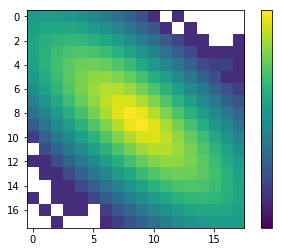

In [34]:
plt.imshow(gal.drawImage(scale=pixel_scale).array,norm=LogNorm())
plt.colorbar()
print np.min(gal.drawImage().array)

In [35]:
# gal = galsim.Sersic(n=0.9,scale_radius = 0.2899613, flux=7.4369873,gsparams=gsparams)
# gal=gal.transform(0.8222,0.260355,0.260355,1.29868)
print gal
gal = galsim.Sersic(n=1.0,half_light_radius=0.108705859505, flux=2.16024879771,gsparams=gsparams)
#gal = gal.shear(galsim.Shear(g1=0.05493919119883436,g2=0.46971950650886507))
gal = gal.shear(galsim.Shear(g1=0.0,g2=0.48))

orig_gal = gal

galsim.Sersic(n=1.0, half_light_radius=0.108705859505, flux=2.16024879771).shear(galsim.Shear(g1=0.05493919119883436,g2=0.46971950650886507))


In [67]:
gridsize=30
x1,x2=np.linspace(0.01,0.9,gridsize),np.linspace(0.01,0.9,gridsize)
e1,e2= np.meshgrid(x1,x2)
mask= e1**2+e2**2>0.9
e1[mask]=np.nan
e2[mask]=np.nan
shears=zip(e1.flatten(),e2.flatten())

In [68]:
st = time.clock()
#shears = [0.,]#np.linspace(0,0.8,11)[1:]
errs = []
shearlist=[]
#print shears
for shear in shears:
    if np.isnan(shear[0]) or np.isnan(shear[1]):
        errs.append((-999,-999))
        continue
    #print shear
    gal = orig_gal.shear(galsim.Shear(e1=shear[0],e2=shear[1]))
    #gal=orig_gal.shear(galsim.Shear(g1=0,g2=shear))
    fin = galsim.Convolve([gal,psf_gaussian])
    given_im = fin.drawImage(scale=pixel_scale, method='no_pixel')

    #gal_interp = fin
    gal_interp = galsim.InterpolatedImage(given_im,gsparams=gsparams)

    inv_gauss = galsim.Deconvolve(gauss_psfii)
    dec = galsim.Convolve(gal_interp,inv_gauss)
    rec = galsim.Convolve(dec, gauss_psfii)

    recIm = rec.drawImage(scale=pixel_scale,method='no_pixel')

    decIm = dec.drawImage(scale=pixel_scale)
    ss=decIm.array.shape[0]
    stamp=galsim.ImageF(ss,ss)
    # plt.imshow(decIm.array - gal.drawImage(image=stamp,scale=pixel_scale).array)
    # plt.colorbar()

    recsize = recIm.array.shape[0]
    origIm = galsim.ImageF(recsize,recsize)
    origIm = fin.drawImage(image=origIm,scale=pixel_scale,method='no_pixel')       
    
#     fig,ax=plt.subplots(1,2)
#     f1=ax[0].imshow(origIm.array,norm=LogNorm(),vmin=1e-6)
#     f2=ax[1].imshow(recIm.array,norm=LogNorm(),vmin=1e-6)
#     fig.colorbar(f1,ax=ax[0])
#     fig.colorbar(f2,ax=ax[1])
#     plt.show()

    # plt.imshow(origIm.array / recIm.array - 1,vmin=-2e-3,vmax=2e-3,cmap=cm.bwr)
    # plt.colorbar()

#     plt.imshow((origIm.array - recIm.array)*1e5,vmin=-2,vmax=2,cmap=cm.bwr)
#     plt.colorbar()
#     plt.show()

    #print np.max(np.abs(origIm.array - recIm.array))

    orig_shape=galsim.hsm.FindAdaptiveMom(origIm).observed_shape
    #print orig_shape.e1, orig_shape.e2

    rec_shape=galsim.hsm.FindAdaptiveMom(recIm).observed_shape
    #print rec_shape.e1, rec_shape.e2

    #e1err,e2err= 1-rec_shape.e1/orig_shape.e1, 1-rec_shape.e2/orig_shape.e2
    e1err, e2err = np.abs(rec_shape.e1-orig_shape.e1), np.abs(rec_shape.e2-orig_shape.e2)
    errs.append((e1err,e2err))
    shearlist.append(shear)
print time.clock() - st

18.389953


In [69]:
e1errs = np.abs(np.array([err[0] for err in errs]))
e2errs = np.abs(np.array([err[1] for err in errs]))

shear1 = np.array([sh[0] for sh in shears]).reshape((gridsize,gridsize))
shear2 = np.array([sh[1] for sh in shears]).reshape((gridsize,gridsize))

In [77]:
e1errs=np.array(e1errs).reshape((gridsize,gridsize))
e2errs=np.array(e2errs).reshape((gridsize,gridsize))
tot_err = np.sqrt(e1errs**2 + e2errs**2)

In [78]:
print len(e2errs)

30


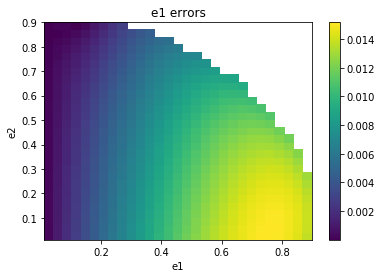

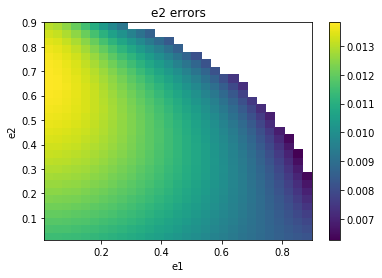

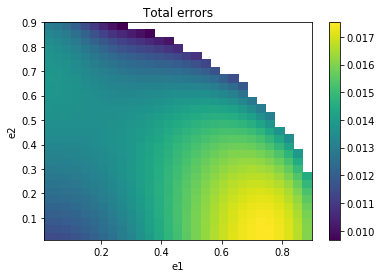

In [80]:
plt.pcolor(shear1,shear2,e1errs)
plt.xlabel('e1')
plt.ylabel('e2')
plt.colorbar()
plt.title('e1 errors')
plt.show()
plt.pcolor(shear1,shear2,e2errs)
plt.xlabel('e1')
plt.ylabel('e2')
plt.colorbar()
plt.title('e2 errors')
plt.show()
plt.pcolor(shear1,shear2,tot_err)
plt.xlabel('e1')
plt.ylabel('e2')
plt.colorbar()
plt.title('Total errors')
plt.show()